<a href="https://colab.research.google.com/github/lynnwongkaree/SC5002/blob/main/SC5002_Lab2_Group12_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle


d973f354c9d32e145c828aed00a6b1c4  haoranfei123


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'haoranfei123'
os.environ['KAGGLE_KEY'] = 'd973f354c9d32e145c828aed00a6b1c4'

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile


with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
    zip_ref.extractall()

import pandas as pd


df_train = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')

df_sub = pd.read_csv('sample_submission.csv')


print("Train head:")
print(df_train.head())
print("\nTest head:")
print(df_test.head())
print("\nSample Submission head:")
print(df_sub.head())


Train head:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# 1️⃣ 处理 categorical 变量
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

# 保证 train/test 列对齐
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns.drop('SalePrice'), fill_value=0)

# 2️⃣ 填充数值列缺失值
num_cols = df_train_encoded.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('SalePrice')
for col in num_cols:
    median = df_train_encoded[col].median()
    df_train_encoded[col] = df_train_encoded[col].fillna(median)
    df_test_encoded[col] = df_test_encoded[col].fillna(median)

# 3️⃣ 拆分特征和目标
X_train = df_train_encoded.drop('SalePrice', axis=1)
y_train = np.log1p(df_train_encoded['SalePrice'])  # log 转换
X_test = df_test_encoded

# 4️⃣ 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ RidgeCV 自动调参
alphas = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train_scaled, y_train)
print("Best alpha:", ridge_cv.alpha_)

# 交叉验证 RMSE
scores = cross_val_score(ridge_cv, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("Ridge CV RMSE scores:", rmse_scores)
print("Ridge CV RMSE mean:", rmse_scores.mean())

# 6️⃣ 预测测试集
y_pred_log = ridge_cv.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # 还原原始房价

# 7️⃣ 生成提交文件
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': y_pred
})
submission.to_csv('submission_ridge.csv', index=False)
print("Submission file saved!")




Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Best alpha: 300.0
Ridge CV RMSE scores: [0.12229283 0.15501736 0.14021192 0.12295375 0.17961621]
Ridge CV RMSE mean: 0.14401841402964588
Submission file saved!


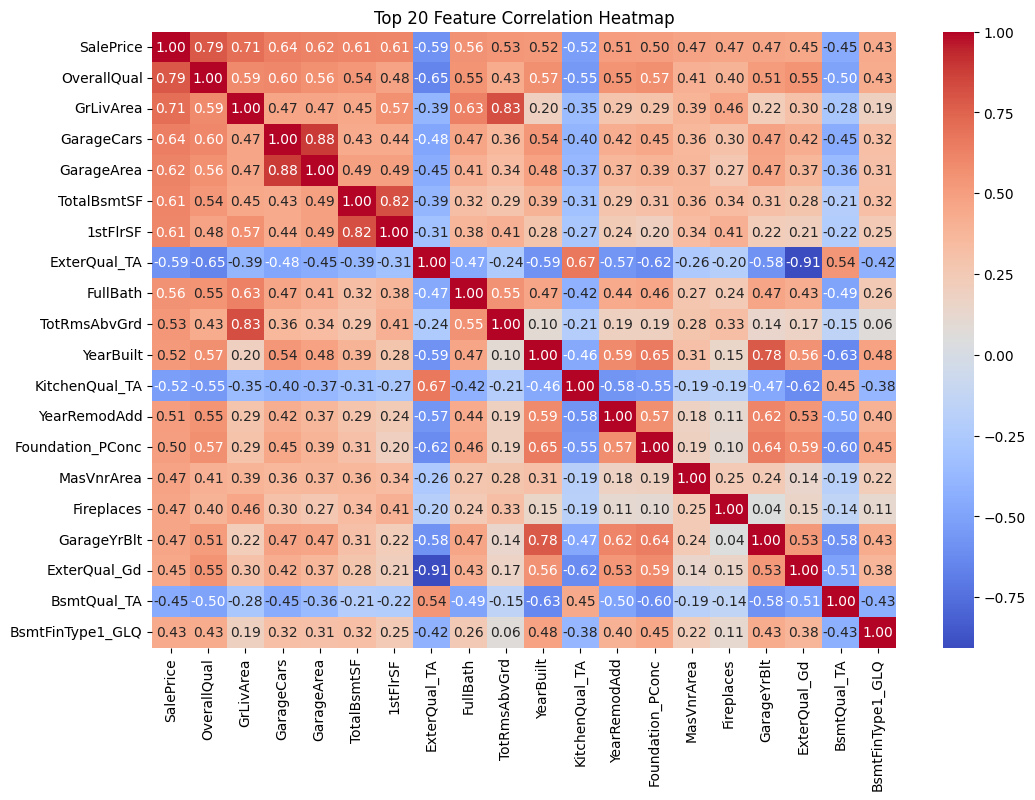

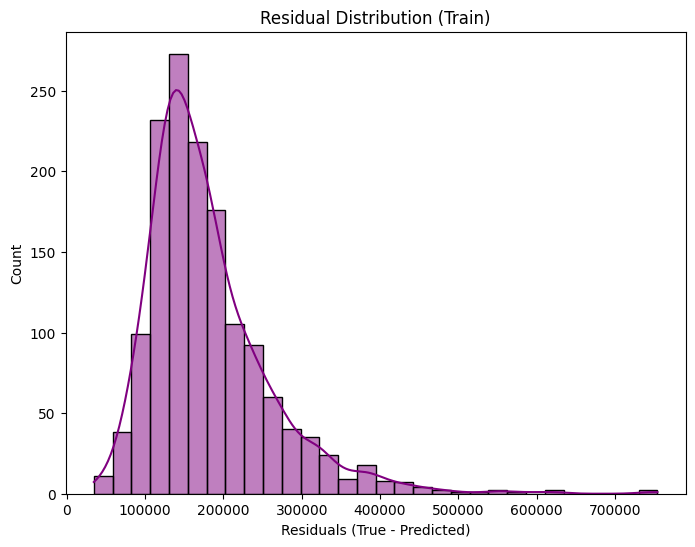

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


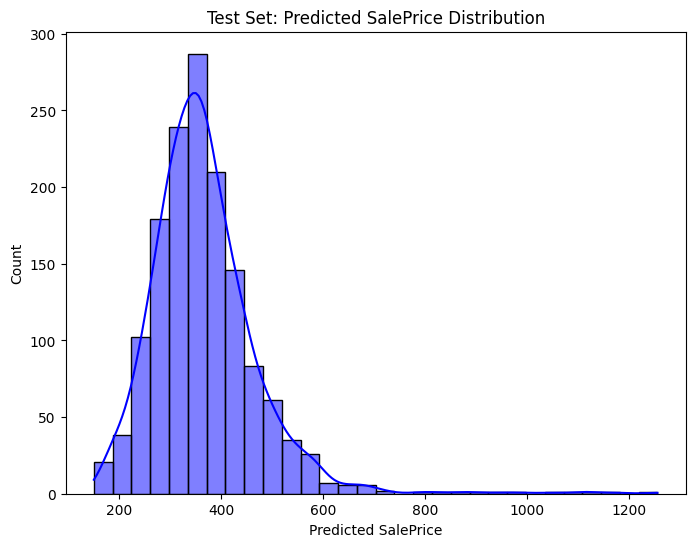

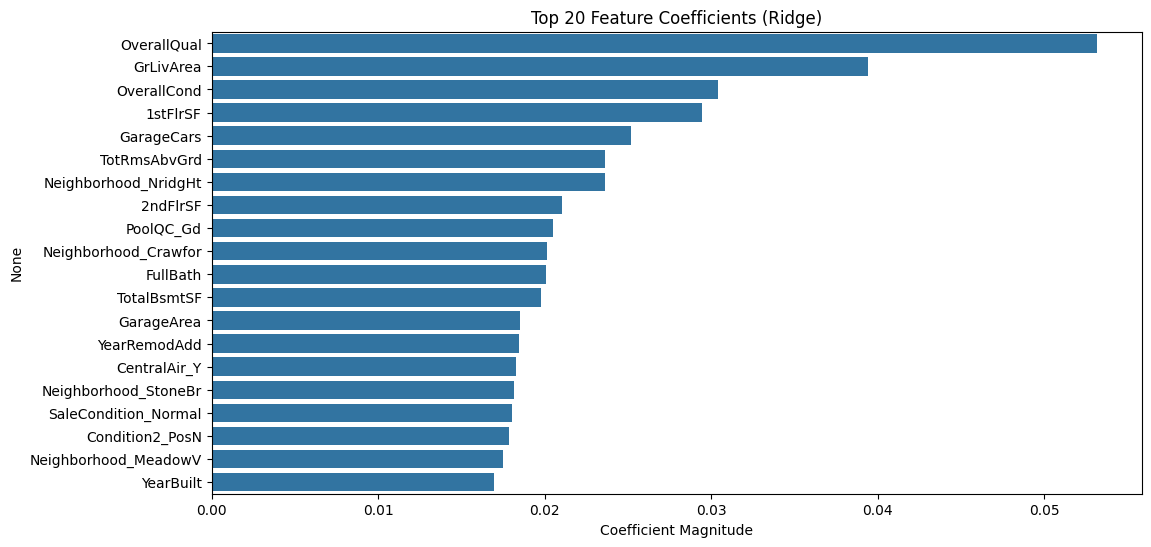

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -----------------------------
# 0️⃣ Prepare encoded data for correlation and model
# -----------------------------
# Identify categorical columns
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

# Align test set columns
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns.drop('SalePrice'), fill_value=0)

# Fill missing numerical values with median
num_cols = df_train_encoded.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('SalePrice')  # Don't fill target
for col in num_cols:
    median = df_train_encoded[col].median()
    df_train_encoded[col] = df_train_encoded[col].fillna(median)
    df_test_encoded[col] = df_test_encoded[col].fillna(median)

X_train = df_train_encoded.drop('SalePrice', axis=1)
y_train = df_train_encoded['SalePrice']
X_test = df_test_encoded

# -----------------------------
# 1️⃣ Correlation Heatmap (Top 20 features)
# -----------------------------
corr_matrix = df_train_encoded.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(20).index

plt.figure(figsize=(12,8))
sns.heatmap(df_train_encoded[top_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Top 20 Feature Correlation Heatmap")
plt.show()

# -----------------------------
# 2️⃣ Training Set: True vs Predicted SalePrice
# -----------------------------
# y_train_pred = ridge_cv.predict(X_train)

# plt.figure(figsize=(8,6))
# sns.scatterplot(x=y_train, y=y_train_pred)
# plt.plot([y_train.min(), y_train.max()],
#          [y_train.min(), y_train.max()],
#          color='red', linestyle='--')
# plt.xlabel("True SalePrice")
# plt.ylabel("Predicted SalePrice")
# plt.title("Training Set: True vs Predicted SalePrice")
# plt.show()

# -----------------------------
# 3️⃣ Training Set: Residual Distribution
# -----------------------------
residuals = y_train - y_train_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.xlabel("Residuals (True - Predicted)")
plt.title("Residual Distribution (Train)")
plt.show()

# -----------------------------
# 4️⃣ Test Set: Predicted SalePrice Distribution
# -----------------------------
y_test_pred = ridge_cv.predict(X_test)
plt.figure(figsize=(8,6))
sns.histplot(y_test_pred, kde=True, bins=30, color='blue')
plt.xlabel("Predicted SalePrice")
plt.title("Test Set: Predicted SalePrice Distribution")
plt.show()

# -----------------------------
# 5️⃣ Ridge Feature Coefficients (Top 20)
# -----------------------------
ridge_coeffs = pd.Series(ridge_cv.coef_, index=X_train.columns)
top_coeffs = ridge_coeffs.abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_coeffs.values, y=top_coeffs.index)
plt.title("Top 20 Feature Coefficients (Ridge)")
plt.xlabel("Coefficient Magnitude")
plt.show()


